In [16]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


In [4]:
data_inicial = "2014-01-01"
data_final = "2024-01-01"


url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-2014'&@dataFinalCotacao='01-01-2024'&$top=10000&$format=json&$select=cotacaoVenda,dataHoraCotacao"


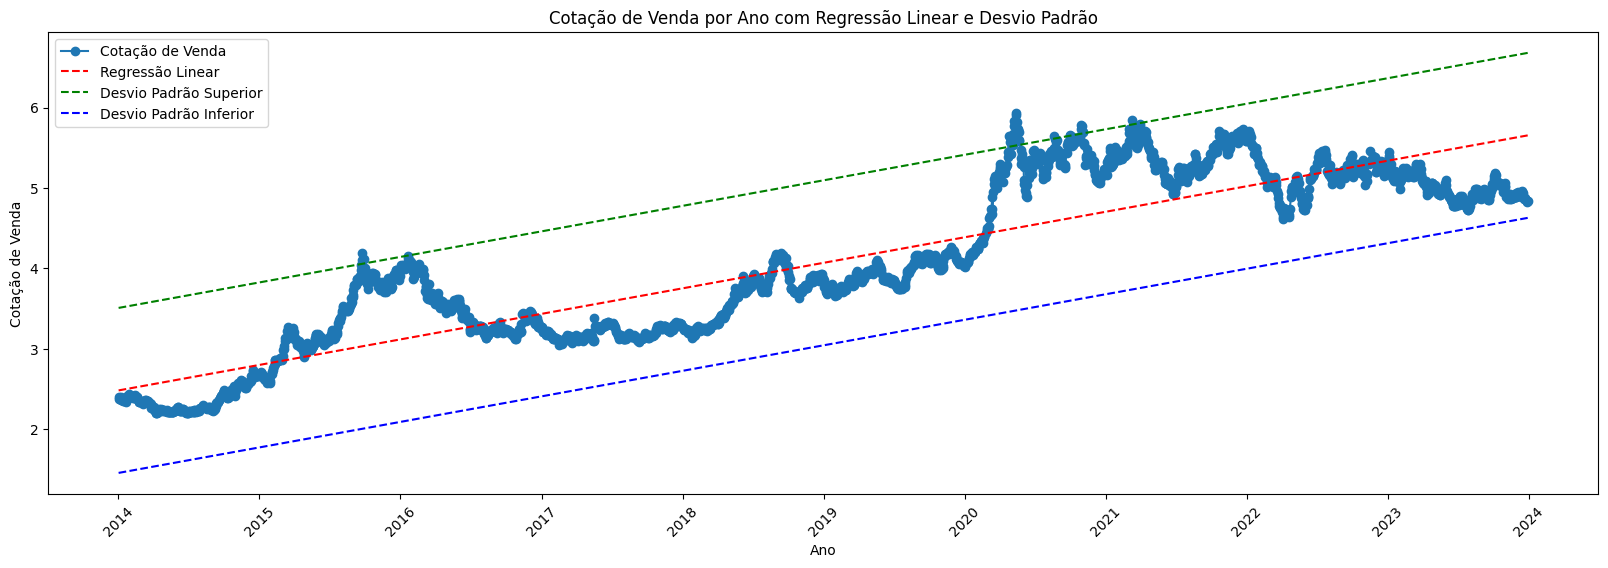

In [18]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Requisição da API
response = requests.get(url)
dados = response.json()

# Converte os dados para um DataFrame
df = pd.DataFrame(dados["value"])

# Extraindo apenas a parte da data e convertendo para datetime
df['data'] = pd.to_datetime(df['dataHoraCotacao'].str.split().str[0])

# Converte as datas para valores numéricos (necessário para np.polyfit)
df['data_num'] = mdates.date2num(df['data'])

# Regressão linear
coef = np.polyfit(df['data_num'], df['cotacaoVenda'], 1)  
poly1d_fn = np.poly1d(coef)  

# Calcula o desvio padrão da cotação de venda
std_dev = df['cotacaoVenda'].std()

# Criando o gráfico
plt.figure(figsize=(20,6))

# Plotando os pontos reais
plt.plot(df['data'], df['cotacaoVenda'], label="Cotação de Venda", marker='o', linestyle='-')

# Adicionando a linha de regressão
plt.plot(df['data'], poly1d_fn(df['data_num']), color='red', linestyle='--', label="Regressão Linear")

# Adicionando as linhas de desvio padrão
plt.plot(df['data'], poly1d_fn(df['data_num']) + std_dev, color='green', linestyle='--', label="Desvio Padrão Superior")
plt.plot(df['data'], poly1d_fn(df['data_num']) - std_dev, color='blue', linestyle='--', label="Desvio Padrão Inferior")

# Formatando o eixo X para exibir os anos
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Adicionando título e rótulos
plt.title('Cotação de Venda por Ano com Regressão Linear e Desvio Padrão')
plt.xlabel('Ano')
plt.ylabel('Cotação de Venda')
plt.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.show()
